# HSE 2024: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [ ]:
%pip install --upgrade pip
%pip install matplotlib
%pip install numpy
%pip install seaborn
%pip install scipy
%pip install -U scikit-learn
%pip install --user -U nltk
%pip install --upgrade nltk
!python3 -m nltk.downloader popular

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

1. Gradient of Logistic Loss: $$\frac{∂L_{log}}{∂w_j} = \sum_{i=1}^{N}(σ(w^Tx_i) - y_i)x_{ij}$$
2. Gradient of L1: $$\frac{∂L_{L1}}{∂w_j} = γ \cdot sign(w_j)$$
3. Gradient of L2: $$\frac{∂L_{L2}}{∂w_j} = 2β \cdot w_j$$
4. Total gradient: $$\frac{∂L_{log}}{∂w_j} = \sum_{i=1}^{N}(σ(w^Tx_i) - y_i)x_{ij} + γ \cdot sign(w_j) + 2β \cdot w_j$$


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [ ]:
from scipy.stats import logistic

def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    X = np.array(X)
    y = np.array(y)
    w = np.array(w)
    N, K = X.shape

    logits = X.dot(w)
    sigma = logistic.cdf(logits)
    sigma = np.clip(sigma, 1e-10, 1 - 1e-10)

    log_loss = -y * np.log(sigma) - (1 - y) * np.log(1 - sigma)
    logistic_loss = np.sum(log_loss)

    L1_reg = gamma * np.sum(np.abs(w))
    L2_reg = beta * np.sum(w**2)

    total_loss = logistic_loss + L1_reg + L2_reg
    return total_loss

#### 3. [0.25 points] Implement the gradient (as a function)

In [ ]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> List[float]:
    X = np.array(X)
    y = np.array(y)
    w = np.array(w)

    wx = X.dot(w)
    sigm = logistic.cdf(wx)

    grad_logistic = X.T.dot(sigm - y)
    grad_L1 = gamma * np.sign(w)
    grad_L2 = 2 * beta * w

    grad = grad_logistic + grad_L1 + grad_L2
    return grad.tolist()

#### Check yourself

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)

grad_w = get_grad(X, y, w)
print(grad_w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

[-3.994474929359763, -1.8478672277855597, 0.6452010421087129, 1.6705997291223376, -5.0385848672792095, -5.214963362606359]


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, learning_rate=1e-3, tolerance=0.01, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.w = None
        self.loss_history = None
        self.classes_ = np.array([0, 1])
        # you may additional properties if you wish

    def fit(self, X, y):
        l, d = X.shape
        # Initialize weights
        self.w = np.random.randn(d)
        #self.w = np.zeros(d)
        self.loss_history = []

        for iteration in range(self.max_iter):
          #if (iteration % 1 == 0):
          #  print(iteration)

          gradient = np.array(get_grad(X, y, self.w, self.gamma, self.beta))
          self.w -= self.learning_rate * gradient

          cur_loss = loss(X, y, self.w, self.gamma, self.beta)
          #print(cur_loss)
          self.loss_history.append(cur_loss)

          if np.linalg.norm(self.w - (self.w - self.learning_rate * gradient)) < self.tolerance:
                #print(iteration)
                break

        return self

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        predict = np.where(np.dot(X, self.w) > 0.5, 1, 0)
        return np.where(np.dot(X, self.w) > 0.5, 1, 0)

    def predict_proba(self, X):
      #proba_class_1 = 1 / (1 + np.exp(-np.dot(X, self.w)))  # Probability of class 1
      #proba_class_0 = 1 - proba_class_1  # Probability of class 0
      #return np.column_stack((proba_class_0, proba_class_1))

      # return vector of probabilities for each object from X
        return (np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])).T

In [ ]:
# sample data to test your model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.metrics import *
def show_results(test_y, pred, proba):
    print("Precision: {0:6.5f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.5f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.5f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.5f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC: {0:6.5f}".format(roc_auc_score(test_y, proba[:,1]),))

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

Without division into training and testing

Precision: 0.93938
Recall: 0.93889
F1-measure: 0.93887
Accuracy: 0.93889
ROC-AUC: 0.98136


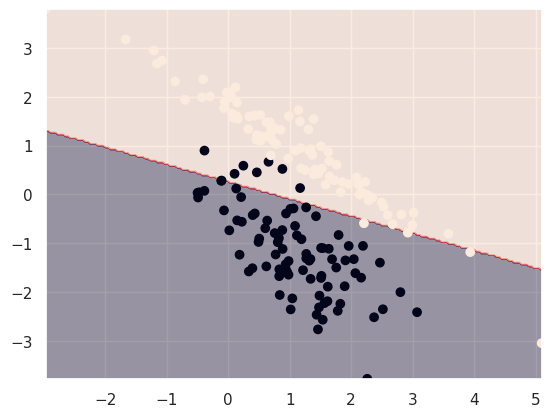

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)
show_results(y, model.predict(X), model.predict_proba(X))

Divide into train and test

Train:
Precision: 0.95040
Recall: 0.94842
F1-measure: 0.94810
Accuracy: 0.94815
ROC-AUC: 0.98244
Test:
Precision: 0.97917
Recall: 0.97727
F1-measure: 0.97773
Accuracy: 0.97778
ROC-AUC: 0.99407


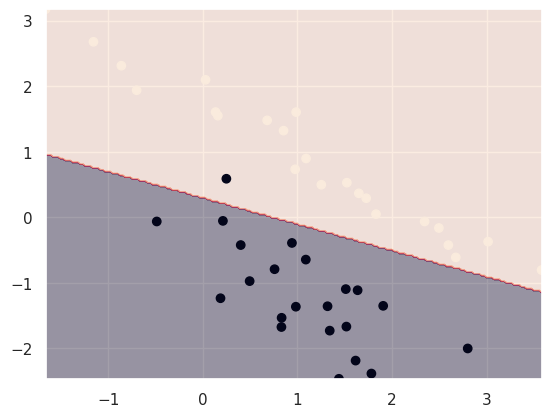

In [ ]:
model = Logit(0, 0)
model.fit(X_train, y_train)
plot_decision_boundary(model, X_test, y_test)
print(f'Train:')
show_results(y_train, model.predict(X_train), model.predict_proba(X_train))
print(f'Test:')
show_results(y_test, model.predict(X_test), model.predict_proba(X_test))

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

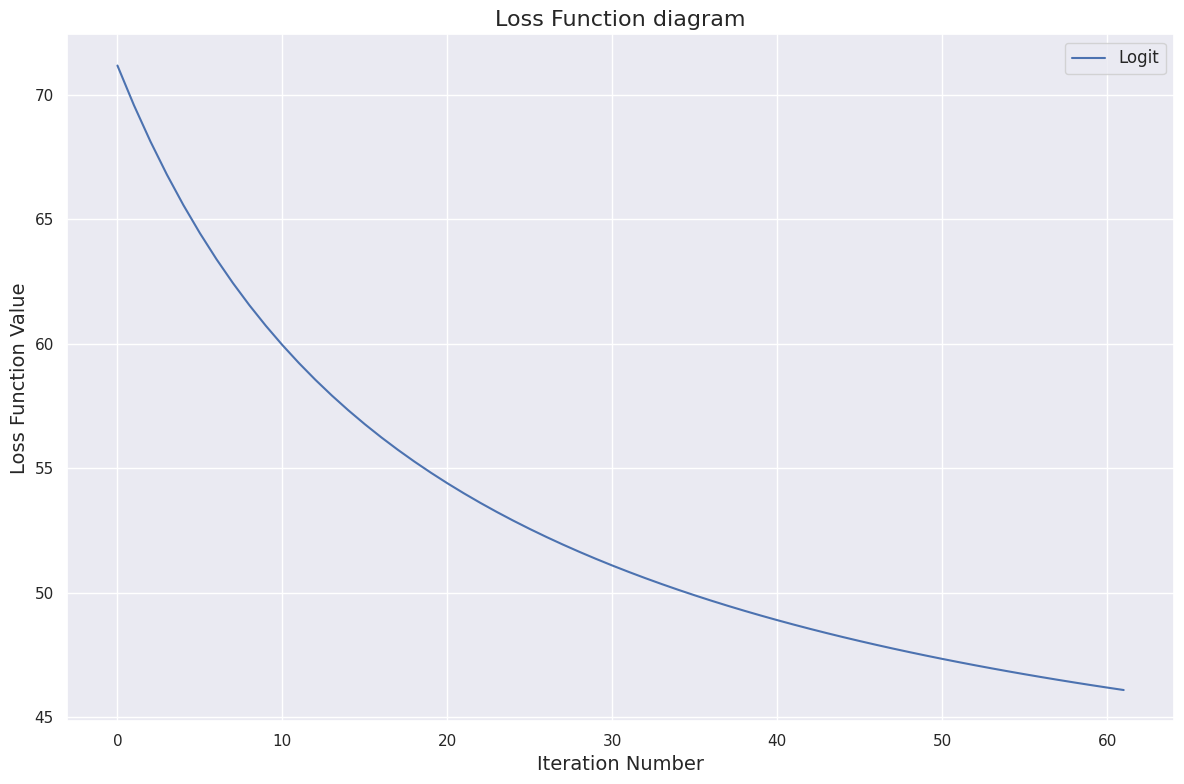

In [ ]:
# your code here
model = Logit(0, 0)
model.fit(X, y)
loss_histories = {"Logit" : model.loss_history}
plt.figure(figsize=(12, 8))
for model_name, loss_history in loss_histories.items():
    plt.plot(loss_history, label=model_name)

# Customize the plot
plt.title('Loss Function diagram', fontsize=16)
plt.xlabel('Iteration Number', fontsize=14)
plt.ylabel('Loss Function Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

Divide into train and test

In [ ]:
# Функция для отображения всех метрик (accuracy, ROC AUC, F1 score) на одном графике
def plot_all_kernels_С_metrix(params):
  C_values = np.logspace(-2, 2, 5)

  # Подготовим фигуру для графиков
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))

  # Графики для каждого ядра и метрики
  for i, kernel in enumerate(params.keys()):
    accuracy = params[kernel]['accuracy']
    roc_auc = params[kernel]['roc_auc']
    f1_score = params[kernel]['f1_score']

    # Accuracy
    axes[i].plot(C_values, accuracy, label='Accuracy', marker='o')
    axes[i].plot(C_values, roc_auc, label='ROC AUC', marker='s')
    axes[i].plot(C_values, f1_score, label='F1 Score', marker='^')

    axes[i].set_xscale('log')
    axes[i].set_xlabel('C (log scale)')
    axes[i].set_ylabel('Score')
    axes[i].set_title(f'{kernel.capitalize()} Kernel')
    axes[i].legend()

  # Показываем графики
  plt.tight_layout()
  plt.show()


In [ ]:
# Функция для отображения всех метрик (accuracy, ROC AUC, F1 score) на одном графике
def plot_all_metrix_kernels(params):
  C_values = np.logspace(-2, 2, 5)

  # Подготовим фигуру для графиков
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))

  # Графики для каждой метрики (accuracy, roc_auc, f1_score)
  metrics = ['accuracy', 'roc_auc', 'f1_score']
  for i, metric in enumerate(metrics):
    axes[i].plot(C_values, params['linear'][metric], label='Linear', marker='o')
    axes[i].plot(C_values, params['poly'][metric], label='Poly', marker='s')
    axes[i].plot(C_values, params['rbf'][metric], label='RBF', marker='^')
    axes[i].plot(C_values, params['sigmoid'][metric], label='Sigmoid', marker='x')

    axes[i].set_xscale('log')
    axes[i].set_xlabel('C (log scale)')
    axes[i].set_ylabel('Score')
    axes[i].set_title(f'{metric.capitalize()} for different kernels')
    axes[i].legend()

# Покажем графики
  plt.tight_layout()
  plt.show()

In [ ]:
# Функция для отображения всех метрик (accuracy, ROC AUC, F1 score) на одном графике
def plot_extra(params, name, param_grid):
  xlab = ""
  X_val = []
  if (name == 'poly'):
    xlab = 'degree'
    X_val = param_grid['poly']['degree']
  elif (name == 'rbf'):
    xlab = 'gamma'
    X_val = param_grid['rbf']['gamma']
  elif (name == 'sigmoid'):
    xlab = 'coef0'
    X_val = param_grid['sigmoid']['coef0']

   # Графики для каждого ядра и метрики

  accuracy = params[name]['accuracy']
  roc_auc = params[name]['roc_auc']
  f1_score = params[name]['f1_score']

    # Accuracy
  plt.plot(X_val, accuracy, label='Accuracy', marker='o')
  plt.plot(X_val, roc_auc, label='ROC AUC', marker='s')
  plt.plot(X_val, f1_score, label='F1 Score', marker='^')

  plt.xscale('log')
  plt.xlabel(xlab)
  plt.ylabel('Score')
  plt.title(f'{name.capitalize()} Kernel')
  plt.legend()

  # Показываем графики
  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.svm import SVC

param_grid = {
    'linear': {'C': np.logspace(-2, 2, 5)},
    'poly': {'C': np.logspace(-2, 2, 5), 'degree': [2, 3, 4, 5, 6, 7]},
    'rbf': {'C': np.logspace(-2, 2, 5), 'gamma': np.logspace(-2, 1, 4)},
    'sigmoid': {'C': np.logspace(-2, 2, 5), 'coef0': [0, 0.2, 0.5, 0.7, 1, 1.3]},
}

graph_data = {
    'linear': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
    'poly': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
    'rbf': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
    'sigmoid': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
}

extra_graph_data = {
    'poly': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
    'rbf': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
    'sigmoid': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
}


for kernel, kernel_data in param_grid.items():
  for coef in param_grid[kernel]['C']:
    clf = SVC(verbose = False, probability = True, kernel = kernel, C = coef)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    proba  = clf.predict_proba(X_test)
    graph_data[kernel]['accuracy'].append(accuracy_score(y_test, pred))
    graph_data[kernel]['roc_auc'].append(roc_auc_score(y_test, proba[:,1]))
    graph_data[kernel]['f1_score'].append(f1_score(y_test, pred))


for kernel, kernel_data in param_grid.items():
  tmp = ""
  if (kernel == 'poly'):
    tmp = 'degree'
  elif (kernel == 'rbf'):
    tmp = 'gamma'
  elif (kernel == 'sigmoid'):
    tmp = 'coef0'
  else:
    continue

  for coef in param_grid[kernel][tmp]:
    if (kernel == 'poly'): clf = SVC(verbose = False, probability = True, kernel = kernel, degree = coef)
    if (kernel == 'rbf'): clf = SVC(verbose = False, probability = True, kernel = kernel, gamma = coef)
    if (kernel == 'sigmoid'): clf = SVC(verbose = False, probability = True, kernel = kernel, coef0 = coef)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    proba  = clf.predict_proba(X_test)
    extra_graph_data[kernel]['accuracy'].append(accuracy_score(y_test, pred))
    extra_graph_data[kernel]['roc_auc'].append(roc_auc_score(y_test, proba[:,1]))
    extra_graph_data[kernel]['f1_score'].append(f1_score(y_test, pred))

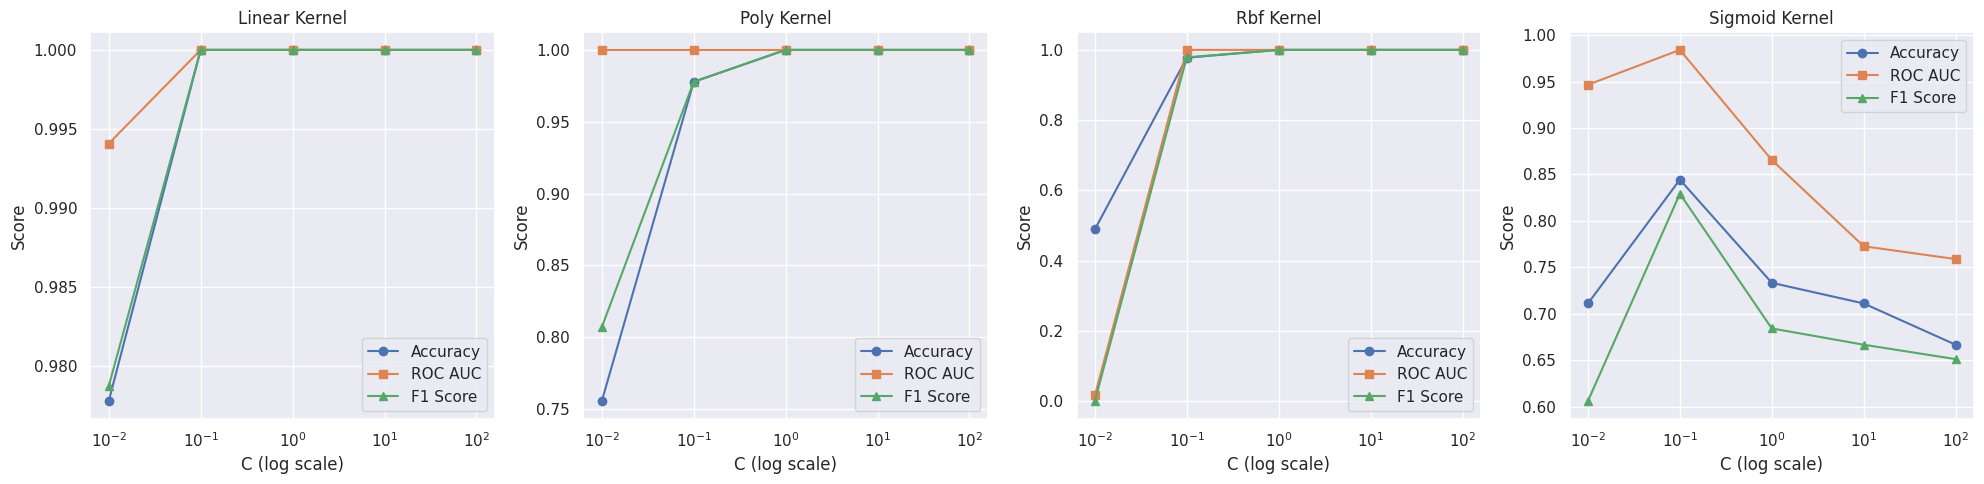

In [ ]:
plot_all_kernels_С_metrix(graph_data)

Linear poly and rbf models show the best results for all 3 metrics at large C. Rbf has very poor results for small C. Sigmoid is inferior to the other 3 algorithms and shows the best result at approximately equal to $0.1$.

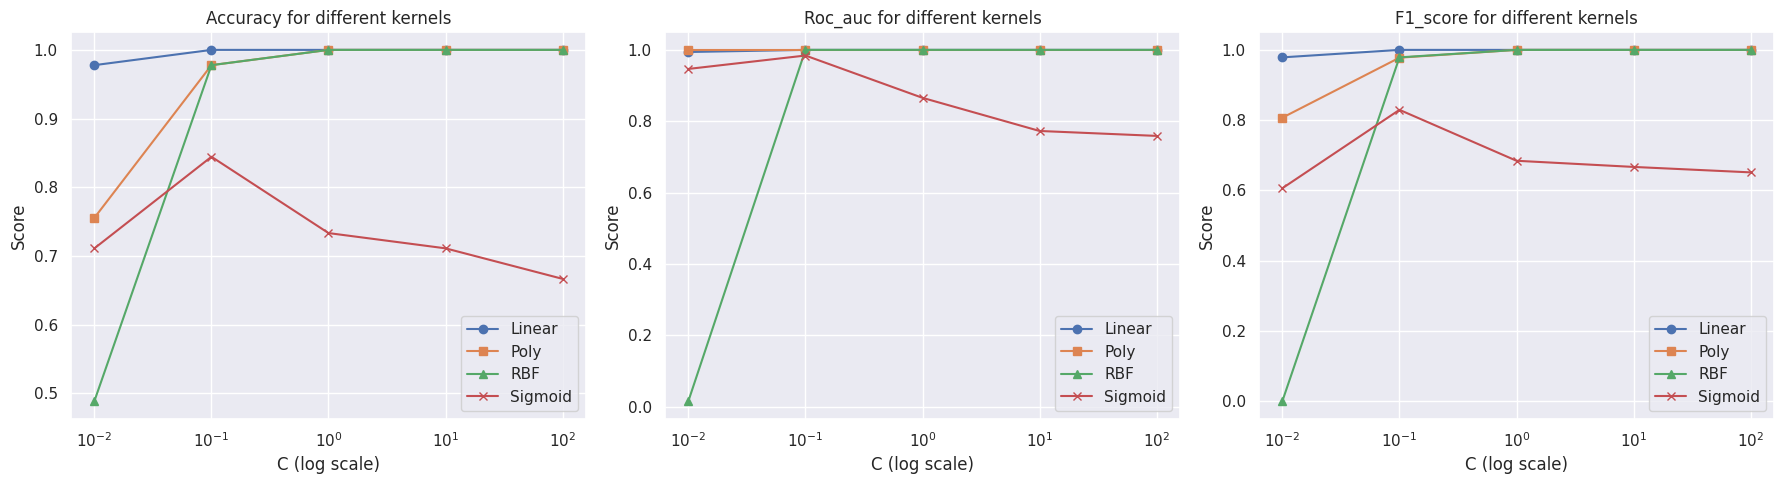

In [ ]:
plot_all_metrix_kernels(graph_data)

Rbf performs very poorly for small C on all metrics. sigmoid is inferior to the other 3 algorithms and shows the best result with approximately equal to $0.1$.

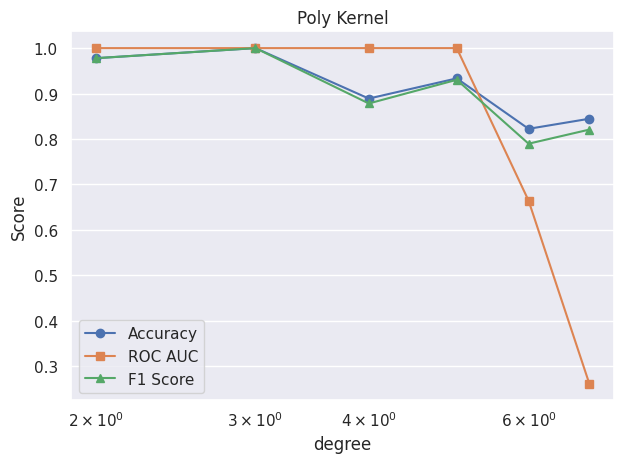

In [ ]:
plot_extra(extra_graph_data, 'poly', param_grid)

Increasing the degree too much will result in worse results.

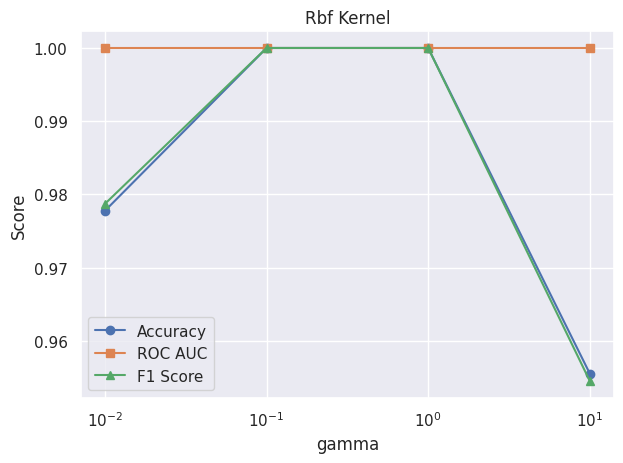

In [ ]:
plot_extra(extra_graph_data, 'rbf', param_grid)

Shows good results throughout the entire segment, but is best from $0.1$ to $1$.

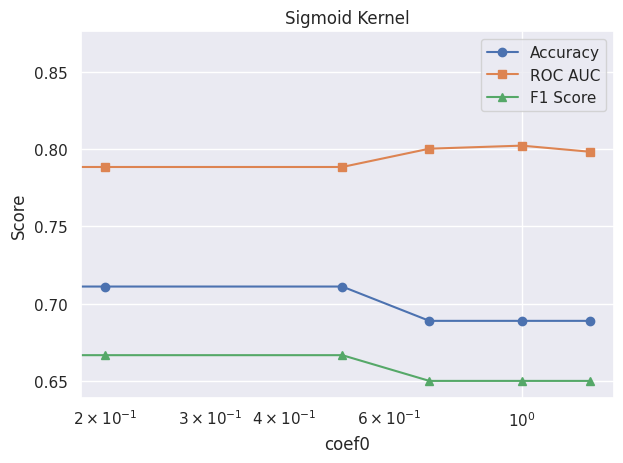

In [ ]:
plot_extra(extra_graph_data, 'sigmoid', param_grid)

As the coefficient increases, accuracity and f1 score drop slightly, but ROC AUC increases slightly too.

The linear kernel shows consistently high performance across all metrics with increasing $C$, indicating robustness and low risk of overfitting. The polynomial kernel achieves high scores with moderate values of $C$, but as $C$ increases, it may become more prone to overfitting. The RBF kernel achieves high scores across metrics as $C$ increases, but it can also become prone to overfitting with very high $C$ values. The sigmoid kernel shows lower and declining performance as $C$ increases. While it does not appear to overfit in this case, the sigmoid kernel is generally less effective for most tasks and can be unstable.

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

##### Task 7.1.
Build your own dataset for these authors

In [ ]:
import os
import random
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk

# Set up NLTK to download and look for resources in a custom directory
nltk_download_dir = '/home/user/Mathematical-methods-of-data-analysis/nltk'
nltk.download('all', download_dir=nltk_download_dir)
nltk.download('punkt', download_dir=nltk_download_dir)
nltk.data.path.append(nltk_download_dir)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/user/Mathematical-
[nltk_data]    |     methods-of-data-analysis/nltk...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/user/Mathematical-methods-of-data-
[nltk_data]    |     analysis/nltk...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/user/Mathematical-methods-of-data-
[nltk_data]    |     analysis/nltk...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/user/Mathematical-methods-of-data-
[nltk_data]    |     analysis/nltk...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | 

In [ ]:
data_path = 'data/prose'
author_proportions = {"Herzen": 5000, "Bryusov": 15000, "Chekhov": 8000, "Dostoevsky": 11000, "Gogol": 20000, "Gorky": 3000}
author_proportions = {author: int(proportion / 2) for author, proportion in author_proportions.items()}

# Initialize DataFrame to store sentences and authors
df = pd.DataFrame(columns=["sentence", "author"])

def process_author_texts(author_folder, author_name, sample_size):
    sentences = []
    for filename in os.listdir(author_folder):
        if filename.endswith('.txt'):
            with open(os.path.join(author_folder, filename), 'r', encoding='utf-8') as file:
                text = file.read().strip()
                author_sentences = sent_tokenize(text)
                author_sentences = [sentence for sentence in author_sentences if len(sentence) >= 15]
                sentences.extend([(sentence, author_name) for sentence in author_sentences])

    # Sample a subset of sentences
    random.seed(42)
    sampled_sentences = random.sample(sentences, min(sample_size, len(sentences)))
    author_df = pd.DataFrame(sampled_sentences, columns=["sentence", "author"])
    return author_df

# Process texts for each author and concatenate them into the main DataFrame
for author_name, sample_size in author_proportions.items():
    author_folder = os.path.join(data_path, author_name)
    author_df = process_author_texts(author_folder, author_name, sample_size)
    df = pd.concat([df, author_df], ignore_index=True)

# Display resulting DataFrame
df

,sentence,author
0,Он грустными толпами гулял около общего гроба ...,Herzen
1,"пить со мною, он поделикатился, он меня уважил...",Herzen
2,"Ну, его и расстреляли.",Herzen
3,"- И притом еще отборные нумера, не так, как зд...",Herzen
4,"Я\n приглянулся ее отцу, и он предлагал, как ...",Herzen
...,...,...
30995,"Давай сядем на лавочку, что-то я устала…\n ...",Gorky
30996,"Он добрый, Николай, — собак любит, мышей и вся...",Gorky
30997,"Так бы и жил всё, так бы всё и действовал!..",Gorky
30998,"— Музыка, — объяснил я.",Gorky


In [ ]:
author_sentence_counts = df['author'].value_counts()
print(author_sentence_counts)

author
Gogol         10000
Bryusov        7500
Dostoevsky     5500
Chekhov        4000
Herzen         2500
Gorky          1500
Name: count, dtype: int64


##### Task 7.2.
Preprocess (tokenize and clean) the dataset

In [ ]:
%pip install pymorphy2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pymorphy2
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import string

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())

    tokens = [morph.parse(word)[0].normal_form for word in tokens
              if word not in stop_words and word not in string.punctuation and not word.isdigit() and word != "-" and word != "—"]

    return ' '.join(tokens)


df['processed_sentence'] = df['sentence'].apply(preprocess)
df

,sentence,author,processed_sentence
0,Он грустными толпами гулял около общего гроба ...,Herzen,грустный толпа гулять около общий гроб падший ...
1,"пить со мною, он поделикатился, он меня уважил...",Herzen,пить я поделикатиться уважить гонение время мо...
2,"Ну, его и расстреляли.",Herzen,расстрелять
3,"- И притом еще отборные нумера, не так, как зд...",Herzen,притом отборный нумера сплошь рядом
4,"Я\n приглянулся ее отцу, и он предлагал, как ...",Herzen,приглянуться отец предлагать похиротоннсагот ж...
...,...,...,...
30995,"Давай сядем на лавочку, что-то я устала…\n ...",Gorky,давать сесть лавочка что-то устала… сель ворот...
30996,"Он добрый, Николай, — собак любит, мышей и вся...",Gorky,добрый николай собака любить мышь всякий тварь...
30997,"Так бы и жил всё, так бы всё и действовал!..",Gorky,жить всё всё действовать ..
30998,"— Музыка, — объяснил я.",Gorky,музыка объяснить


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_bow = CountVectorizer(max_features = 500)
bow_matrix = vectorizer_bow.fit_transform(df['processed_sentence'])

vectorizer_tfidf = TfidfVectorizer(max_features = 500)
tfidf_matrix = vectorizer_tfidf.fit_transform(df['processed_sentence'])

bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_bow.get_feature_names_out())
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

df['bow'] = list(bow_df.values)
df['tfidf'] = list(tfidf_df.values)


In [ ]:
df

,sentence,author,processed_sentence,bow,tfidf
0,Он грустными толпами гулял около общего гроба ...,Herzen,грустный толпа гулять около общий гроб падший ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"пить со мною, он поделикатился, он меня уважил...",Herzen,пить я поделикатиться уважить гонение время мо...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Ну, его и расстреляли.",Herzen,расстрелять,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"- И притом еще отборные нумера, не так, как зд...",Herzen,притом отборный нумера сплошь рядом,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"Я\n приглянулся ее отцу, и он предлагал, как ...",Herzen,приглянуться отец предлагать похиротоннсагот ж...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
30995,"Давай сядем на лавочку, что-то я устала…\n ...",Gorky,давать сесть лавочка что-то устала… сель ворот...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30996,"Он добрый, Николай, — собак любит, мышей и вся...",Gorky,добрый николай собака любить мышь всякий тварь...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30997,"Так бы и жил всё, так бы всё и действовал!..",Gorky,жить всё всё действовать ..,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30998,"— Музыка, — объяснил я.",Gorky,музыка объяснить,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31000 entries, 0 to 30999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sentence            31000 non-null  object
 1   author              31000 non-null  object
 2   processed_sentence  31000 non-null  object
 3   bow                 31000 non-null  object
 4   tfidf               31000 non-null  object
dtypes: object(5)
memory usage: 1.2+ MB


BoW provides simple frequency counts, which are useful for basic tasks but may not highlight the uniqueness or relevance of words in specific contexts.
TF-IDF improves this by weighing words based on their importance across the corpus, helping to filter out common words and highlight unique terms per document.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [ ]:
def show_confusion_matrix(test_y, pred, proba, task):
    print("Precision: {0:6.5f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.5f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.5f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.5f}".format(accuracy_score(test_y, pred)))
    if (task != "task10"): print("ROC-AUC  =  {0:6.5f}".format(roc_auc_score(test_y, proba[:,1]),))
    print('\n')
    if (task != "task10"): labels = ['negative','positive']
    else: labels = author_proportions.keys()

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

In [ ]:
def plot_grid_search_results(grid_search):
    """
    Строит графики для анализа результатов GridSearchCV.

    grid_search: обученный объект GridSearchCV.
    """

    # Получаем результаты из grid_search
    results = grid_search.cv_results_

    # Преобразуем в DataFrame для удобства анализа
    results_df = pd.DataFrame(results)

    # График F1-score в зависимости от разных значений 'vectorizer__max_features' и 'classifier__C'
    plt.figure(figsize=(10, 6))
    pivot_table = results_df.pivot_table(index='param_vectorizer__max_features',
                                         columns='param_classifier__C', 
                                         values='mean_test_score')
    sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Heatmap: Mean F1-score vs. Max Features and C parameter')
    plt.ylabel('Max Features')
    plt.xlabel('C Parameter')
    plt.show()

    # График изменения F1-score в зависимости от 'classifier__beta' (для примера)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='param_classifier__beta', y='mean_test_score', marker='o')
    plt.title('F1-score vs. Beta')
    plt.xlabel('Beta')
    plt.ylabel('Mean Test Score (F1-score)')
    plt.grid(True)
    plt.show()

    # График изменения F1-score в зависимости от 'classifier__learning_rate'
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='param_classifier__learning_rate', y='mean_test_score', marker='o')
    plt.title('F1-score vs. Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean Test Score (F1-score)')
    plt.grid(True)
    plt.show()

    # График зависимости F1 от различных параметров через subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Влияние max_features на F1
    sns.lineplot(data=results_df, x='param_vectorizer__max_features', y='mean_test_score', ax=axes[0, 0], marker='o')
    axes[0, 0].set_title('F1-score vs. Max Features')
    axes[0, 0].set_xlabel('Max Features')
    axes[0, 0].set_ylabel('F1-score')

    # Влияние C на F1
    sns.lineplot(data=results_df, x='param_classifier__C', y='mean_test_score', ax=axes[0, 1], marker='o')
    axes[0, 1].set_title('F1-score vs. C')
    axes[0, 1].set_xlabel('C')
    axes[0, 1].set_ylabel('F1-score')

    # Влияние beta на F1
    sns.lineplot(data=results_df, x='param_classifier__beta', y='mean_test_score', ax=axes[1, 0], marker='o')
    axes[1, 0].set_title('F1-score vs. Beta')
    axes[1, 0].set_xlabel('Beta')
    axes[1, 0].set_ylabel('F1-score')

    # Влияние learning_rate на F1
    sns.lineplot(data=results_df, x='param_classifier__learning_rate', y='mean_test_score', ax=axes[1, 1], marker='o')
    axes[1, 1].set_title('F1-score vs. Learning Rate')
    axes[1, 1].set_xlabel('Learning Rate')
    axes[1, 1].set_ylabel('F1-score')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Filter the DataFrame to only include sentences from two authors
df_filtered = df[df['author'].isin(['Herzen', 'Chekhov'])]

# Check the balance of classes (number of sentences per author)
class_counts = df_filtered['author'].value_counts()
print("Class balance:")
print(class_counts)

Class balance:
author
Chekhov    4000
Herzen     2500
Name: count, dtype: int64


In [ ]:
# Extract the labels (authors)
df_filtered = df[df['author'].isin(['Herzen', 'Chekhov'])]
X = np.array(df_filtered['processed_sentence'].tolist())


# Encode the labels as numeric values (Herzen -> 0, Chekhov -> 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_filtered['author'])

##### Logistic Regression
##### Grid Search

###### TfidfVectorizer

In [ ]:
from multiprocessing import cpu_count
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Векторизация текста
    ('classifier', Logit())  # Ваш кастомный классификатор
])

# Сетка гиперпараметров для поиска
param_grid = {
    
    'vectorizer__max_features': [500, 1000, 3000],

    # Параметры для вашего логистического регрессора
    'classifier__beta': [0.0, 0.1],
    'classifier__gamma': [0.0, 0.1, 0.2],
    'classifier__learning_rate': [1e-4, 1e-3, 1e-2],
    'classifier__tolerance': [0.001, 0.01],
    'classifier__max_iter': [100, 1000, 7000]
}


grid_search_tf = GridSearchCV(
    estimator=pipeline,  # Пайплайн для поиска
    param_grid=param_grid,  # Гиперпараметры
    scoring=make_scorer(f1_score, average='macro'),  # Оценка качества по макро F1
    n_jobs=cpu_count() - 2,  # Используем все ядра, кроме двух (для многозадачности)
    cv=2,  # Кросс-валидация с 5 фолдами
    verbose=2  # Подробный вывод
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

grid_search_tf.fit(X_train, y_train)

best_model_tf = grid_search_tf.best_estimator_

# Выводим лучшие параметры и лучший результат
print("Best Parameters:", grid_search_tf.best_params_)
print("Best F1 Score:", grid_search_tf.best_score_)

NameError: name 'Pipeline' is not defined

In [ ]:
plot_grid_search_results(grid_search_tf)

In [ ]:
print(f'Train:')
show_confusion_matrix(y_train, best_model_tf.predict(X_train), best_model_tf.predict_proba(X_train), task="task8")

In [ ]:
print(f'\nTest:')
show_confusion_matrix(y_test, best_model_tf.predict(X_test), best_model_tf.predict_proba(X_test), task="task8")

###### CountVectorizer

In [ ]:
from multiprocessing import cpu_count
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),  # Векторизация текста
    ('classifier', Logit())  # Ваш кастомный классификатор
])

# Сетка гиперпараметров для поиска
param_grid = {
    
    'vectorizer__max_features': [500, 1000, 3000],

    # Параметры для вашего логистического регрессора
    'classifier__beta': [0.0, 0.1],
    'classifier__gamma': [0.0, 0.1, 0.2],
    'classifier__learning_rate': [1e-4, 1e-3, 1e-2],
    'classifier__tolerance': [0.001, 0.01],
    'classifier__max_iter': [100, 1000, 7000]
}


grid_search_cv = GridSearchCV(
    estimator=pipeline,  # Пайплайн для поиска
    param_grid=param_grid,  # Гиперпараметры
    scoring=make_scorer(f1_score, average='macro'),  # Оценка качества по макро F1
    n_jobs=cpu_count() - 2,  # Используем все ядра, кроме двух (для многозадачности)
    cv=2,  # Кросс-валидация с 5 фолдами
    verbose=2  # Подробный вывод
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

grid_search_cv.fit(X_train, y_train)

best_model_cv = grid_search_cv.best_estimator_

# Выводим лучшие параметры и лучший результат
print("Best Parameters:", grid_search_cv.best_params_)
print("Best F1 Score:", grid_search_cv.best_score_)

In [ ]:
plot_grid_search_results(grid_search_tf)

In [ ]:
print(f'Train:')
show_confusion_matrix(y_train, best_model_tf.predict(X_train), best_model_tf.predict_proba(X_train), task="task8")

In [ ]:
print(f'\nTest:')
show_confusion_matrix(y_test, best_model_tf.predict(X_test), best_model_tf.predict_proba(X_test), task="task8")

All metric values range from approximately $0.6$ to $0.7$. It is better to take the maximum number of features from 300 to 3000. With an increase in the number, the accuracy does not improve much, but it works much longer. Big mistake in False Negatives

##### Support Vector Classification
###### Grid Search

In [ ]:
def plot_grid_search_results(grid_search):
    """
    Строит графики для анализа результатов GridSearchCV.
    
    grid_search: обученный объект GridSearchCV.
    """

    # Получаем результаты из grid_search
    results = grid_search.cv_results_

    # Преобразуем в DataFrame для удобства анализа
    results_df = pd.DataFrame(results)

    # График F1-score в зависимости от разных значений 'vectorizer__max_features' и 'classifier__C'
    plt.figure(figsize=(10, 6))
    pivot_table = results_df.pivot_table(index='param_vectorizer__max_features',
                                         columns='param_classifier__C', 
                                         values='mean_test_score')
    sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Heatmap: Mean F1-score vs. Max Features and C parameter')
    plt.ylabel('Max Features')
    plt.xlabel('C Parameter')
    plt.show()

    # График изменения F1-score в зависимости от 'classifier__C'
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='param_classifier__C', y='mean_test_score', marker='o')
    plt.title('F1-score vs. C')
    plt.xlabel('C')
    plt.ylabel('Mean Test Score (F1-score)')
    plt.grid(True)
    plt.show()

    # График изменения F1-score в зависимости от 'vectorizer__max_features'
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='param_vectorizer__max_features', y='mean_test_score', marker='o')
    plt.title('F1-score vs. Max Features')
    plt.xlabel('Max Features')
    plt.ylabel('Mean Test Score (F1-score)')
    plt.grid(True)
    plt.show()

In [ ]:
logit_param_grid = {
    'vectorizer__max_features': [500, 1000, 3000],  # Параметры для TfidfVectorizer
    'classifier__C': [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 1, 2, 4, 6, 8, 10, 50, 70, 100],  # Параметры для SVC
}

# Создание пайплайна с TfidfVectorizer и SVC
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Векторизация текста
    ('classifier', SVC(verbose=False, probability=True, kernel='linear'))  # SVC с линейным ядром
])

# Инициализация GridSearchCV с F1-score в качестве метрики
grid_search_SVC = GridSearchCV(
    pipeline,  # Пайплайн для поиска
    logit_param_grid,  # Гиперпараметры для поиска
    scoring='f1',  # Используем F1-меру для оценки
    cv=3,  # Кросс-валидация с 3 фолдами
    n_jobs=cpu_count() - 2,  # Используем все ядра, кроме двух
    verbose=2  # Подробный вывод
)

# Обучение с GridSearchCV
grid_search_SVC.fit(X_train, y_train)

best_model_SVC = grid_search_SVC.best_estimator_

# Лучшие параметры после GridSearchCV
print("Best parameters found:", grid_search_SVC.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ..............................................C=0.6; total time=  46.8s
[CV] END ..............................................C=0.4; total time=  47.2s
[CV] END ..............................................C=0.6; total time=  47.5s
[CV] END ..............................................C=0.6; total time=  47.6s
[CV] END ..............................................C=0.4; total time=  48.5s
[CV] END ..............................................C=0.4; total time=  48.6s
[CV] END ..............................................C=0.2; total time=  49.7s
[CV] END ..............................................C=0.2; total time=  50.5s
[CV] END ..............................................C=0.2; total time=  50.5s
[CV] END ..............................................C=0.1; total time=  51.5s
[CV] END ..............................................C=0.1; total time=  52.0s
[CV] END .......................................

In [ ]:
plot_grid_search_results(grid_search_SVC)

In [ ]:
print(f'Train:')
show_confusion_matrix(y_train, best_model_SVC.predict(X_train), best_model_SVC.predict_proba(X_train), task="task8")

In [ ]:
print(f'Test:')
show_confusion_matrix(y_test, best_model_SVC.predict(X_test), best_model_SVC.predict_proba(X_test), task="task8")

All metric values range from approximately $0.6$ to $0.7$. It is better to take the maximum number of features from 300 to 3000. With an increase in the number, the accuracy does not improve much, but it works much longer. The error in False Negatives has become smaller, which has improved the model

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

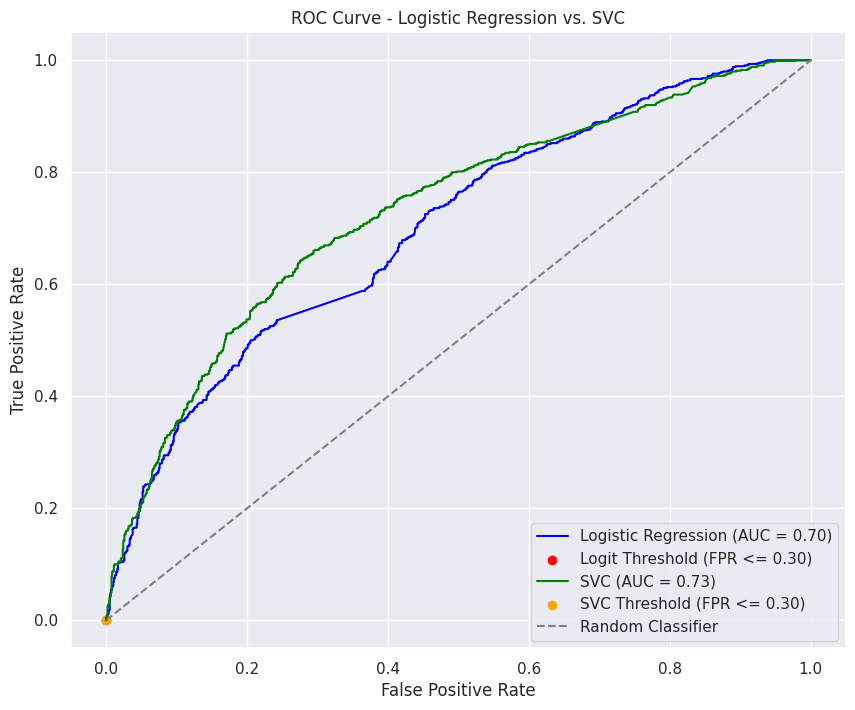

In [ ]:
# your code here
# Custom Logistic Regression (your Logit class should be defined as before)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

logit_model = Logit(**grid_search_best_par)
logit_model.fit(X_train, y_train)

# Train SVC model
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)

# Get probabilities (Logistic Regression & SVC)
y_logit_prob = logit_model.predict_proba(X_test)[:, 1]  # Probability for class 1
y_svc_prob = svc_model.predict_proba(X_test)[:, 1]  # Probability for class 1

# Compute ROC curve and AUC
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_test, y_logit_prob)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_svc_prob)

# Find threshold with FPR <= 0.30 for Logit
threshold_logit_30 = thresholds_logit[np.where(fpr_logit <= 0.30)[0][0]] if np.any(fpr_logit <= 0.30) else None
# Find threshold with FPR <= 0.30 for SVC
threshold_svc_30 = thresholds_svc[np.where(fpr_svc <= 0.30)[0][0]] if np.any(fpr_svc <= 0.30) else None

# Plot ROC curve
plt.figure(figsize=(10, 8))

# Plot Logistic Regression ROC curve
plt.plot(fpr_logit, tpr_logit, color='blue', label='Logistic Regression (AUC = {:.2f})'.format(auc(fpr_logit, tpr_logit)))
if threshold_logit_30 is not None:
    plt.scatter(fpr_logit[np.where(thresholds_logit == threshold_logit_30)], tpr_logit[np.where(thresholds_logit == threshold_logit_30)], color='red', label='Logit Threshold (FPR <= 0.30)')

# Plot SVC ROC curve
plt.plot(fpr_svc, tpr_svc, color='green', label='SVC (AUC = {:.2f})'.format(auc(fpr_svc, tpr_svc)))
if threshold_svc_30 is not None:
    plt.scatter(fpr_svc[np.where(thresholds_svc == threshold_svc_30)], tpr_svc[np.where(thresholds_svc == threshold_svc_30)], color='orange', label='SVC Threshold (FPR <= 0.30)')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random Classifier')

# Customize plot
plt.title('ROC Curve - Logistic Regression vs. SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [ ]:
# your code here
from sklearn.multiclass import OneVsOneClassifier

y = df['author']
label_encoder = LabelEncoder()
y_encoded2 = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(np.array(df['tfidf'].tolist()), y_encoded2, test_size=0.3, random_state=42, stratify=y_encoded2)
#X_train, X_test, y_train, y_test = train_test_split(np.array(df['bow'].tolist()), y_encoded2, test_size=0.3, random_state=42)

y_train

array([0, 2, 3, ..., 0, 0, 1])

In [ ]:
from multiprocessing import cpu_count
from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'estimator__beta': [0.0, 0.1],
#    'estimator__gamma': [0.0, 0.1],
#    'estimator__learning_rate': [1e-4, 1e-3],
#    'estimator__tolerance': [0.001, 0.0001],
#    'estimator__max_iter': [1000],
#}


#logit_model = Logit(**grid_search_best_par)
# Wrap the Logit model in a OneVsOneClassifier for multiclass support
#ovo_classifier = OneVsOneClassifier(logit_model)

#scorer = make_scorer(f1_score, average='macro')  # macro for multiclass F1 score

# Create the GridSearchCV object
#grid_search_multi = GridSearchCV(
#    estimator=ovo_classifier,
#    param_grid=param_grid,
#    scoring=scorer,
#    n_jobs=cpu_count() - 2,
#    cv=2, 
#    verbose=2
#)

# Fit the grid search to find the best parameters
#grid_search_multi.fit(X_train, y_train)

# Display the best parameters and best score
#print("Best Parameters:", grid_search_multi.best_params_)
#print("Best F1 Score:", grid_search_multi.best_score_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END estimator__beta=0.0, estimator__gamma=0.1, estimator__learning_rate=0.0001, estimator__max_iter=1000, estimator__tolerance=0.0001; total time=19.1min
[CV] END estimator__beta=0.0, estimator__gamma=0.1, estimator__learning_rate=0.0001, estimator__max_iter=1000, estimator__tolerance=0.001; total time=19.2min
[CV] END estimator__beta=0.0, estimator__gamma=0.1, estimator__learning_rate=0.0001, estimator__max_iter=1000, estimator__tolerance=0.0001; total time=19.2min
[CV] END estimator__beta=0.0, estimator__gamma=0.1, estimator__learning_rate=0.0001, estimator__max_iter=1000, estimator__tolerance=0.001; total time=19.2min
[CV] END estimator__beta=0.1, estimator__gamma=0.0, estimator__learning_rate=0.0001, estimator__max_iter=1000, estimator__tolerance=0.001; total time=19.2min
[CV] END estimator__beta=0.0, estimator__gamma=0.1, estimator__learning_rate=0.001, estimator__max_iter=1000, estimator__tolerance=0.0001; total ti

In [ ]:
logit_model = Logit(**grid_search_best_par)

# Create the One-vs-One classifier using your Logit model as the base classifier
ovo_classifier = OneVsOneClassifier(logit_model, n_jobs = cpu_count() - 2)

# Fit the One-vs-One classifier on the training data
ovo_classifier.fit(X_train, y_train)

NameError: name 'cpu_count' is not defined

In [ ]:

print("Train")
show_confusion_matrix(y_train, ovo_classifier.predict(X_train), np.zeros((len(y_train), 2)), 'task10')

Test
Precision: 0.35233
Recall: 0.31101
F1-measure: 0.30831
Accuracy: 0.40075




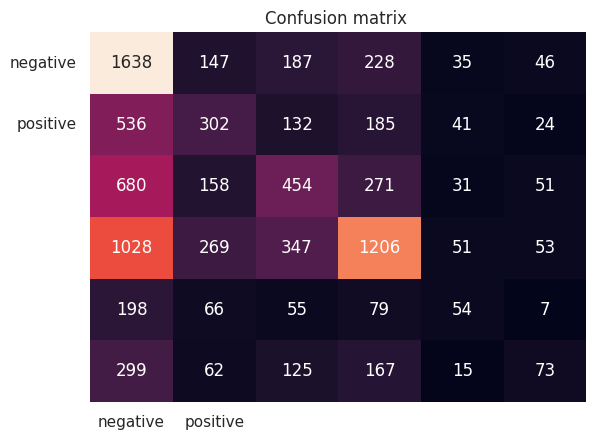

In [ ]:
print("Test")
show_confusion_matrix(y_test, ovo_classifier.predict(X_test), np.zeros((len(y_test), 2)), 'task10')